# What are those cells doing?

### This lesson will help you analyze a dataset from the Allen Brain Institute's Brain Observatory.

These datasets contain calcium imaging data for various different cell types in the visual cortex of the mouse. It's likely that these cell types have different roles in the visual system -- your mission is to figure out what these roles are. You will choose a visual area, a cell type, and look at their responses to natural stimuli:

<img src="ExperimentalDesign.png">  

### By the end of this lesson, you will be able to:
1. Choose a dataset for a particular cell type, in a specific visual area.
2. Plot a stimulus-response curve for one neuron.

Additional information on this dataset, and how it was collected, can be found <a href="http://help.brain-map.org/display/observatory/Data+-+Visual+Coding">here</a> as well as in the <a href="https://media.readthedocs.org/pdf/allensdk/latest/allensdk.pdf">SDK documentation</a>. 


## Step 1. Importing toolboxes
<b>First, we'll import the necessary toolboxes to run this code.</b> The first chunk of "import" lines will bring in some standard toolboxes that we need. For example, "numpy" is a toolbox that has functions to work with large arrays (https://en.wikipedia.org/wiki/NumPy). The second chunk of import lines brings in some toolboxes that the Allen Brain Observatory has already packaged, to help users analyze its data.

In [44]:
# Standard toolboxes
import pprint
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import os

# Allen specific toolboxes
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.natural_scenes import NaturalScenes
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
from allensdk.brain_observatory.static_gratings import StaticGratings

# We will save the Brain Observatory Cache as a variable, "boc."
boc = BrainObservatoryCache(manifest_file='/datasets/allen-brain-observatory/visual-coding-2p/manifest.json')
cwd = os.getcwd()
print('Successfully imported AllenSDK packages.')

Successfully imported AllenSDK packages.


## Step 2. Get a list of all possible trangenic mouse lines and brain areas, and choose which to work with.
Next, we'll ask that "boc" structure to tell us what all of the possible Cre lines and brain areas are that we can analyze. You'll need to use these exact names when you're trying to pull a specific one from the dataset.


In [45]:
# We'll save the list of cre lines as a variable, 'cre-lines'.
cre_lines = boc.get_all_cre_lines()
print("all cre lines: " + str(cre_lines))

# We'll save the list of possible structures as a variable, 'brain_areas'.
brain_areas = boc.get_all_targeted_structures()
print("all brain regions: " + str(brain_areas))

all cre lines: ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Fezf2-CreER', 'Nr5a1-Cre', 'Ntsr1-Cre_GN220', 'Pvalb-IRES-Cre', 'Rbp4-Cre_KL100', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre', 'Slc17a7-IRES2-Cre', 'Sst-IRES-Cre', 'Tlx3-Cre_PL56', 'Vip-IRES-Cre']
all brain regions: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Choose a visual area and Cre line from the lists above to examine in the rest of the notebook. You can find more info about the Cre-lines here (you'll need this for your write-up) <a href="http://help.brain-map.org/display/observatory/Transgenic+Mouse+Lines">here</a>.
</div>

In [126]:
# put the visual area & cre line below in single quotes. e.g. 'VISp'
visual_area = 'VISp'
cre_line = 'Cux2-CreERT2'
print("Let's take a look at how " + str(cre_line)
      + " cells in " + visual_area + " respond to natural scenes. ")

Let's take a look at how Cux2-CreERT2 cells in VISp respond to natural scenes. 


The next bit of code will get the list of all the experiment containers for that area and Cre line combination, and make a data frame so we can see what information we have on these experiments. We can use that table to confirm we've got the data we wanted (from the correct Cre line and structure).

In [133]:
exps = boc.get_experiment_containers(
    targeted_structures=[visual_area],
    cre_lines=[cre_line],)

#create a dataframe and show us the beginning of it
exps_df = pd.DataFrame(exps)
exps_df.head()

,cre_line,donor_name,failed,id,imaging_depth,reporter_line,specimen_name,tags,targeted_structure
0,Cux2-CreERT2,222426,False,511510736,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-222426,[],VISp
1,Cux2-CreERT2,229106,False,511510855,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-229106,[],VISp
2,Cux2-CreERT2,222420,False,511509529,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-222420,[],VISp
3,Cux2-CreERT2,222424,False,511507650,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-222424,[],VISp
4,Cux2-CreERT2,225037,False,511510699,275,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-225037,[],VISp


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Pick an experiment from the table above. Be sure to use the "id" column.
</div>

In [49]:
experiment_container_id = 511498742
print(experiment_container_id)

511498742


Now, we'll get information about all of the experiment <strong>sessions</strong> in your experiment <strong>container</strong>.  This is accomplished with the `get_ophys_experiments` method. Most experiments have three different sessions, for different types of visual stimuli.

In [52]:
expt_cont = boc.get_ophys_experiments(
    experiment_container_ids=[experiment_container_id], 
    stimuli=['natural_scenes'],
)
session_id = expt_cont[0]['id']
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
print('Data acquired for session '+str(session_id))
pd.DataFrame(expt_cont)

Data acquired for session 511434920


,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,id,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
0,91,Scnn1a-Tg3-Cre,231953,511498742,False,511434920,350,Ai93(TITL-GCaMP6f),three_session_B,Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-231953,VISp


## Step 3. Download & inspect the natural scenes imaging session
First, we'll look at the session where the mouse viewed natural scenes.

Let's take a quick look at the data you just acquired. We'll take a maximum projection of the data, so that we can actually see the cells. If we just looked at one snapshot, the cells would look dim. A maximum projection shows us the maximum brightness for each pixel, across the entire experiment.

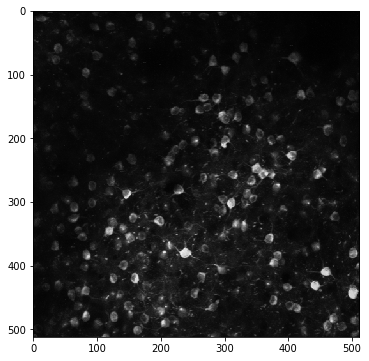

In [53]:
max_projection = data_set.get_max_projection()
fig = plt.figure(figsize=(6,6))
plt.imshow(max_projection, cmap='gray')

Lets see our cells in action! First, we need to prepare a few things...

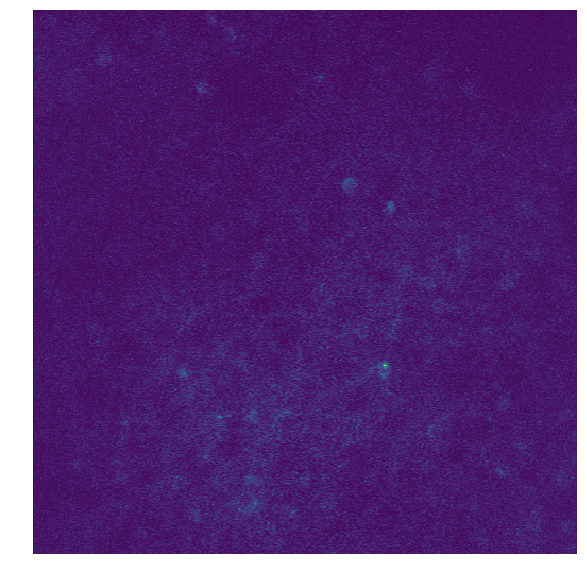

In [54]:
from matplotlib import animation, rc
from IPython.display import HTML

raw_data_dir = '/datasets/allen-brain-observatory/visual-coding-2p/ophys_movies/'
def get_raw_data_path(session_id):
    return os.path.join(raw_data_dir, 'ophys_experiment_'+str(session_id)+'.h5')

exp_path = get_raw_data_path(session_id)
raw_data = h5py.File(exp_path, 'r')
raw_data['data']

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(raw_data['data'][0])
ax.axis('off')

def init():
    im.set_data(raw_data['data'][0])
    return (im,)

def animate(i):
    im.set_data(raw_data['data'][i])
    return (im,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=50, interval=1000./30, blit=True)

Now we can actually play the animation. Run the code below & press play. <b>Note</b> this might take a few seconds to load.

In [ ]:
HTML(anim.to_jshtml())

## Step 4. Look at the calcium transients of your cells

First, let's look at all of the cells in our field of view above.

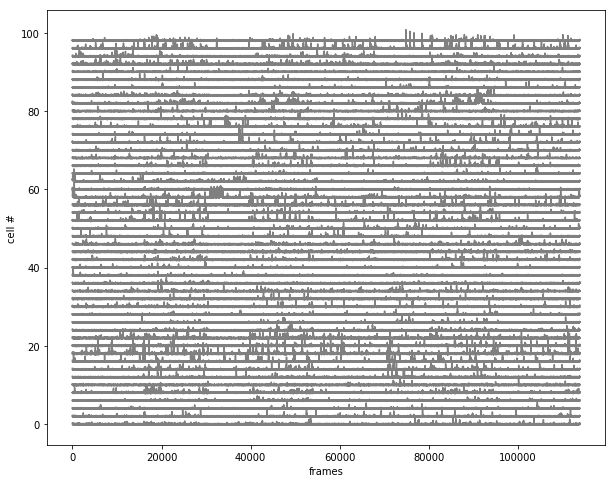

In [57]:
ts, dff = data_set.get_dff_traces()
fig = plt.figure(figsize=(10,8))
for i in range(50):
    plt.plot(dff[i]+(i*2), color='gray')
    plt.xlabel('frames')
    plt.ylabel('cell #')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b> Choose one cell to look at. The plot above gives you an idea of how many cells there are.</div>

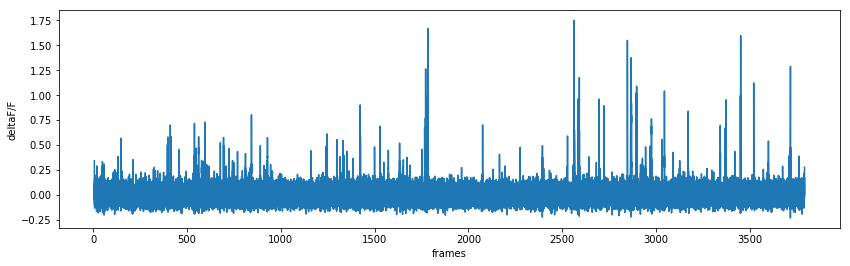

In [56]:
#choose a number somewhere between 0 and the # cells above
my_cell = 18
cell_specimen_ids = data_set.get_cell_specimen_ids()
cell_id = cell_specimen_ids[1]

# get raw traces for that cell
time, raw_traces = data_set.get_fluorescence_traces(cell_specimen_ids=[cell_id])

# plot raw and corrected ROI trace
plt.figure(figsize=(14,4))
plt.plot(time[:len(dff[0])], dff[0])
plt.xlabel('frames')
plt.ylabel('deltaF/F')
plt.show()

## Step 5. Look at the response of your cell to natural scenes
It's tough to see what's going on with just the raw traces. Let's see how these cells actually responded to different types of images.

First, we'll organize the stimulus table. This tells us which stimulus was played on each trial. This data set has 118 different scenes, and each scene is presented 50 times. Images of the scenes can be found here: http://observatory.brain-map.org/visualcoding/stimulus/natural_scenes

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b> Choose one of the natural scenes (there are 118 total). Put next to "image_id" below. Try another one if you're not happy with your first random choice.</div>

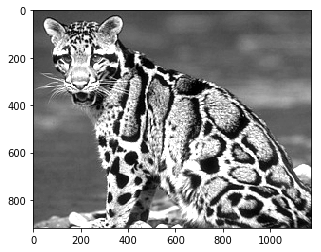

In [60]:
#choose your image id
image_id = 22

natural_scene_table = data_set.get_stimulus_table('natural_scenes')
natural_scene_template = data_set.get_stimulus_template('natural_scenes')
sceneIDs = np.unique(natural_scene_table.frame)

# plot this natural scene
plt.imshow(natural_scene_template[image_id,:,:], cmap='gray')

Now we'll find all of the cells that significantly prefer this stimulus.

In [65]:
# get the experiment_container id for this session
this_expt = expt_cont['id'==session_id]
experiment_container_id = this_expt['experiment_container_id']
cell_specimens = pd.DataFrame(boc.get_cell_specimens())
subset = cell_specimens[cell_specimens.experiment_container_id==experiment_container_id]
subset[(subset.p_ns<0.05)&(subset.pref_image_ns==image_id)].cell_specimen_id

34     517397559
133    517398191
158    517398369
185    517398552
218    517398767
Name: cell_specimen_id, dtype: int64

Let's plot the data of single trials where this cell was shown your images above. If the above doesn't give you any results, change the image above and run it again.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b> Choose one of the cell specimen ids from above and enter it below.</div>

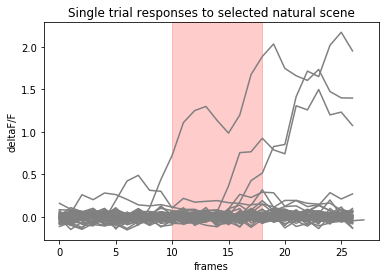

In [68]:
cell_id = 517398191
ts, dff = data_set.get_dff_traces()
cell_index = data_set.get_cell_specimen_indices([cell_id])[0]

stim_subset = natural_scene_table[natural_scene_table.frame==image_id]
for i in range(len(stim_subset)):
    plt.plot(dff[cell_index,stim_subset.start.iloc[i]-10:stim_subset.end.iloc[i]+10], color='gray')
plt.axvspan(10,18, color='red',alpha=0.2)
plt.ylabel('deltaF/F')
plt.xlabel('frames')
plt.title('Single trial responses to selected natural scene')
plt.show()

<b>Save the image above for your lab write-up</b>.

So, a few cells in your dataset like this particular image, but what about all of the cells? And what about all of the other images? To visualize this, we'll plot a histogram of how many cells significantly prefer certain images.

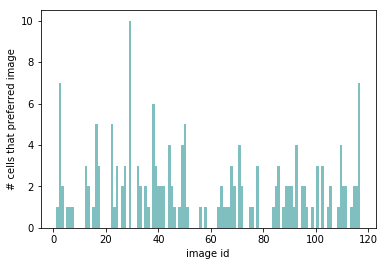

Top image is 28


In [69]:
fig = plt.figure()
axes = subset[(subset.p_ns<0.05)].pref_image_ns.plot(kind="hist",fc=(0, .5,.5, 0.5),bins=117)
axes.set_ylabel('# cells that preferred image')
axes.set_xlabel('image id')
plt.show()

n, bins, patches = ax.hist(subset[(subset.p_ns<0.05)].pref_image_ns, 117, density=1)

print('Top image is '+str(n.argmax()))


Which images do the cells in your experiment actually respond to? Scroll back up to the block where you plotted your first preferred image and change the image ID so that you can see what the image actually is.

<b>Save the histogram above for your lab write-up.<b/>


## Step 6. Examine the direction selectivity of your cell
Sometimes, the function of a cell is not particularly clear from natural stimuli. Those stimuli have a lot of information in them, and it might be hard to tell what a cell is actually responding to. Instead, we can use simple drifting gratings to look at one straightforward property of a cell: <b>does it respond to specific directions of movement?</b></br>

We'll take the same cell you looked at above, but look at its response to drifting gratings. Below, we'll plot the response of this cell to different directions of the grating.

First, let's look at the raw data in response to a single stimulus. The code below will plot several seconds of data during a drifting grating. The stimulus was played while the background of the plot is gray. If there isn't a clear response during the stimulus, change the number in "stim_table.orientation" until you find one.

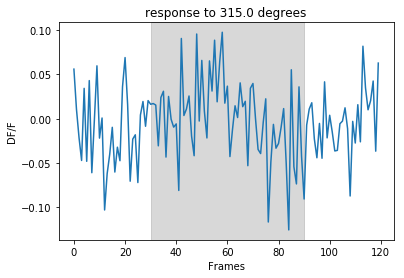

In [31]:
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id],
                stimuli=['drifting_gratings'],targeted_structures=[visual_area],
                cre_lines=[cre_line])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)
timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_id])
dff_trace = dff[0,:]
stim_table = data_set.get_stimulus_table('drifting_gratings')

plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")
plt.title('response to '+ str(stim_table.orientation[stim_id])+' degrees')
plt.show()

This is just the response to one stimulus -- it might be quite noisy. Let's look across all directions of the stimulus, to see if we can find any patterns.

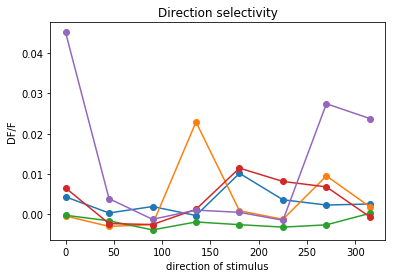

In [135]:
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i]
    cell_response[i,1] = stim_table.temporal_frequency[i]
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()
    
all_ori = np.unique(cell_response[:,0])
orivals = all_ori[np.isfinite(all_ori)]
np.sort(stim_table.orientation.dropna().unique())
tfvals = np.unique(cell_response[:,1])
tfvals = tfvals[np.isfinite(tfvals)]
tuning_array = np.empty((8,5))
for i,ori in enumerate(orivals):
    for j,tf in enumerate(tfvals):
        trials = np.where(np.logical_and(cell_response[:,0]==ori, cell_response[:,1]==tf))[0]
        tuning_array[i,j] = cell_response[trials,2].mean()
for i in range(5):
    plt.plot(orivals, tuning_array[:,i], 'o-')
    plt.xlabel('direction of stimulus')
    plt.ylabel('DF/F')
    plt.title('Direction selectivity')

Is your cell direction selective? In other words, does it clearly respond to one orientation over other orientations? It may also be orientation selective -- responding to two, opposite directions.

<b>Save this plot for your Canvas write-up.</b>

That's all folks. Submit your write-up on Canvas to get your points for the day.

In [137]:
HTML('<img src="https://i.chzbgr.com/full/5107765760/h244F968D/">')